# Transfer Learning using a CNN pretrained on IMAGENET

The objective of this assignment is to perform transfer learning using a Convolutional Neural Network pretrained on the well-known IMAGENET dataset. The chosen task is the classification of images in 4 classes: neutrophil, eosinophil, monocyte and lymphocyte. The dataset is available on kaggle at the following link:
https://www.kaggle.com/paultimothymooney/blood-cells

A VGG16 has been chosen as pre-trained network while, as classification model, after several tests, it has been chosen to operate through a Support Vector Machine.

In [1]:
from google.colab import drive
import os
import zipfile

# Data viz and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DL 
import tensorflow as tf
import cv2                  
from random import shuffle  
from PIL import Image
import random as rn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, make_scorer, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense

from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.vgg16 import preprocess_input

# Inspecting the data and preparing the data

The dataset chosen for this task is a subset of the original one, i.e. 3600 320x240 images with RGB channels have been selected from the folder with the path indicated in the code. These images, as mentioned, represent 4 different classes of blood cells, portrayed in very different situations as you can see in the first plot. Regarding the distribution, the classes are perfectly balanced (even originally). During the construction of the new dataset it was necessary to label the data with the name of the folders in which they were contained. Moreover, it was arbitrarily chosen to crop the images in a 224x224 format keeping the RGB channels. To pre-process the data, we chose to use the same preprocessing applied to the images of the IMAGENET dataset, used to train the imported VGG16 network.

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
zip = zipfile.ZipFile('/content/gdrive/MyDrive/kaggle.zip', 'r')
zip.extractall()
zip.close()

print(os.listdir())

['.config', 'gdrive', 'dataset-master', 'dataset2-master', 'sample_data']


In [4]:
print(os.listdir('dataset2-master/dataset2-master/images/TRAIN'))

['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']


In [5]:
root = 'dataset2-master/dataset2-master/images/TRAIN'

In [6]:
# Import and label data

X = []
Z = []

IMG_SIZE = 224

NEUTROPHIL_DIR = root + '/NEUTROPHIL'
EOSINOPHIL_DIR = root + '/EOSINOPHIL'
MONOCYTE_DIR = root + '/MONOCYTE'
LYMPHOCYTE_DIR = root + '/LYMPHOCYTE'

In [7]:
def assign_label(img, type):
    return type

In [8]:
def new_data(type, DIR):
    for img in os.listdir(DIR)[:900]:
        try:
            label = assign_label(img, type)
            path = os.path.join(DIR, img)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass

In [9]:
LYMPHOCYTE_DIR

'dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE'

In [10]:
new_data('NEUTROPHIL', NEUTROPHIL_DIR)
new_data('EOSINOPHIL', EOSINOPHIL_DIR)
new_data('MONOCYTE', MONOCYTE_DIR)
new_data('LYMPHOCYTE', LYMPHOCYTE_DIR)
print(len(X))

3600


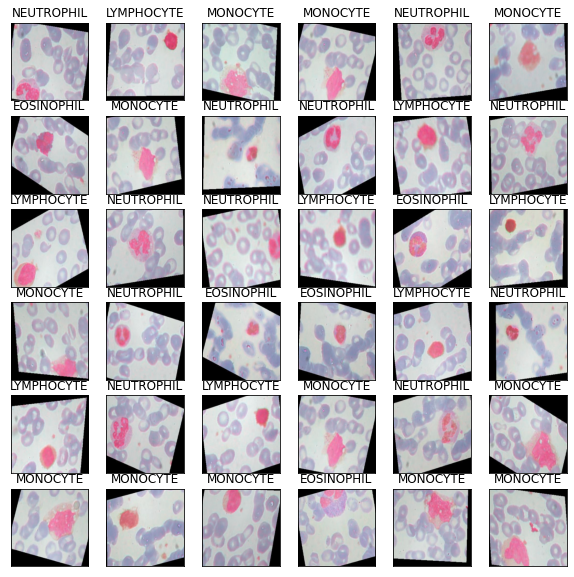

In [11]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(len(X),36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X[image_ind]), cmap=plt.cm.binary)
    label = Z[image_ind]
    plt.title(label)

In [12]:
# We format our labels in numeric format and reduce our list of images to an array of images

le = LabelEncoder()
Y = le.fit_transform(Z)
X = np.array(X)

del Z

In [13]:
# Shuffle 
idx = np.random.permutation(len(X))
X, Y = X[idx], Y[idx]

In [14]:
# Preprocessing equal to the images of the imagenet dataset
img_data = preprocess_input(X)

del X

In [15]:
img_data.shape

(3600, 224, 224, 3)

# Models

In order to fulfill the objective set by the assignment it has been decided to create substantially 3 models based on the
features extracted from 3 different layers of the net:
- the first cut took place at the block5_pool layer;
- the second at the block4_pool layer
- the last one at the layer block3_pool.
For every different cut of the pre-trained model we proceeded substantially to extract the features produced by the passage of the images in the network.
produced from the passage of the images in the net: in the order 25088, 100352 and 200704. Subsequently we proceeded to carry out a PCA in order to preserve the 80% of the explained variance, with the objective to reduce the dimensionality of the features, so to allow the Support Vector Machine to operate in acceptable times and with perfomances. acceptable times and with good performances. 

The 3 realized classification models were optimized in their hyper-parameters through a grid search mechanism, so as to maximize their performance:
- C: [5,10,15];
- kernel: rbf;
- gamma: [auto, scale].

The features, before being subjected to PCA, were scaled to values between 0 and 1 so as to be compatible with the SVM model. Finally, the data were divided into 75% training and 25% test set. 

In [16]:
# Function that extracts features from our images by truncating the network to a certain layer chosen by us.

def extract_features(name_layer, data):
  base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (224,224,3),
                   pooling='avg')
  dims = []
  for dim in base_model.get_layer(name = name_layer).output_shape:
    if dim == None:
      pass
    else:
      dims.append(dim)
  reshaping = np.prod(np.array(dims))

  tmp = Model(base_model.input, base_model.get_layer(name = name_layer).output)
  tmp.summary()
  
  features = tmp.predict(data)
  features = features.reshape((features.shape[0], reshaping))
  print("\nDims {}".format(features.shape))
  del dims, reshaping, tmp, base_model

  return features

In [17]:
# Grid Search Cross Validation to find the best C and gamma values for our Support Vector Machine

param_grid = {'C': [5, 10, 15], 'gamma': ['auto', 'scale']}
svm = GridSearchCV(SVC(class_weight = 'balanced'),
                   param_grid = param_grid,
                   cv = 3,
                   n_jobs = -1)

# block5_pool

The first model was built from the features extracted from the block5_pool layer, i.e., the one closest to the network tail. PCA was used to preserve 80% of the explained variance, which is 1068 components. The optimal parameters found are C=15 and gamma = auto. The performance of the model, which is the best in the entire notebook, indicates an accuracy of 80% (which increases as the data increases).

In [18]:
# The first layer chosen to extract our features is the penultimate one, the block5_pool, the last max pooling layer of the network. 
# At this point of the network our images have reached a size of 7x7x512, therefore extremely deep thanks to the large number of 
# filters but also very small given the size of the image. At this point of the network, therefore, 25088 features are produced for each image.

vgg16_feature = extract_features(name_layer = "block5_pool",
                                 data = img_data)

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [19]:
# Scaling features

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(vgg16_feature)

del vgg16_feature
data_rescaled.shape

(3600, 25088)

In [20]:
# Select 1068 features so as to collect about 80% of the variance explained 

pca = PCA(0.8, copy = False)
dataset = pca.fit_transform(data_rescaled)

del pca
del data_rescaled

dataset.shape

(3600, 1068)

In [21]:
# we proceed to the division into training set and test set.

x_train, x_test, y_train, y_test = train_test_split(dataset,
                                                    Y,
                                                    test_size = .25,
                                                    stratify = Y) 

del dataset

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2700, 1068), (900, 1068), (2700,), (900,))

In [22]:
# The classification reaches rather good performances also considering the difficulty to distinguish the different blood cells: 
# in fact the images are not always clear.

# From the results of the classification report on the test set the classes 2 and 3 are those classified in the most accurate way, 
# this is probably due to its particular structure or to the greater disposition of clean images for those classes


svm.fit(x_train, y_train)
print("Best C value: {C}\nBest gamma value:{gamma}\n".format(C = svm.best_params_['C'],
                                                           gamma = svm.best_params_['gamma']))

y_pred = svm.predict(x_test)

print(classification_report(y_test, y_pred, digits = 3))

Best C value: 15
Best gamma value:auto

              precision    recall  f1-score   support

           0      0.710     0.729     0.719       225
           1      0.853     0.853     0.853       225
           2      0.935     0.902     0.919       225
           3      0.718     0.724     0.721       225

    accuracy                          0.802       900
   macro avg      0.804     0.802     0.803       900
weighted avg      0.804     0.802     0.803       900



# block4_pool

The second model, realized with the objective to go back to the network to verify the eventual positive impact of more generic features extracted from the images, has produced of the performances slightly inferior in comparison to the previous model, with an accuracy of 78%. The PCA in the case of this model, with the same share of variance explained, extracted about 2000 components, while the grid search produced as optimal parameters also for this C = 5 and gamma = auto.

In [18]:
#At this point we proceed with a different level of feature extraction. Going up the network we stop at layer block4_pool, 
# always a max pooling layer at which level the images have reached a size 14x14x512. 
#At this point of the network for each image 100352 features are produced.

vgg16_feature = extract_features(name_layer = 'block4_pool',
                                 data = img_data)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# Scaling features

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(vgg16_feature)

del vgg16_feature
data_rescaled.shape

(3600, 100352)

In [20]:
# In this case, to explain 80% of the variance explained, it is necessary to extract 2000 components with PCA.

pca = PCA(0.8, copy = False)
dataset = pca.fit_transform(data_rescaled)

del pca
del data_rescaled

dataset.shape

(3600, 1466)

In [21]:
# we proceed to the division into training set and test set.

x_train, x_test, y_train, y_test = train_test_split(dataset,
                                                    Y,
                                                    test_size = .25,
                                                    stratify = Y) 

del dataset

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2700, 1466), (900, 1466), (2700,), (900,))

In [22]:
# The performance is slightly lower than before but the substance does not change.

svm.fit(x_train, y_train)
print("Best C value: {C}\nBest gamma value:{gamma}\n".format(C = svm.best_params_['C'],
                                                           gamma = svm.best_params_['gamma']))

y_pred = svm.predict(x_test)

print(classification_report(y_test, y_pred, digits = 3))

Best C value: 5
Best gamma value:auto

              precision    recall  f1-score   support

           0      0.662     0.698     0.680       225
           1      0.825     0.840     0.833       225
           2      0.913     0.889     0.901       225
           3      0.726     0.693     0.709       225

    accuracy                          0.780       900
   macro avg      0.782     0.780     0.781       900
weighted avg      0.782     0.780     0.781       900



# block3_pool

The third and last model has been realized using the features extracted at an even higher level of the network, the block3_pool and among those realized it is the one that has reached the lowest performances. It is also the one that has given more difficulties from the computational point of view: in order not to saturate the RAM, the data have been divided in two distinct sets, inserted one at a time in the process of features extraction and then applied to the PCA before being then gathered and inserted in the SVM. Approximately 882 components were extracted for each set and C = 5 and gamma = scale were chosen as the optimal parameters.

In [18]:
# For computation reasons I divide the data in two parts and execute the following steps taking one part at a time

set_1 = img_data[:1800]
set_2 = img_data[1800:]
first = 1
sets = [set_1, set_2]

In [19]:
# At this level the representation is 28x28x256 for each image. Thus, 200704 features are collected for each instance.

for f in sets:
  vgg16_feature = extract_features(name_layer = 'block3_pool', data = f)
  
  # Scaling features
  scaler = MinMaxScaler(feature_range=[0, 1])
  data_rescaled = scaler.fit_transform(vgg16_feature)

  del vgg16_feature

  pca = PCA(0.8, copy = False)
  dataset = pca.fit_transform(data_rescaled)

  del pca, data_rescaled

  if first==1:
    first=0
  else:
    dataset = np.concatenate([dataset, dataset])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
# We extract 882 components to recover 80% of the explained variance.

dataset.shape

(3600, 882)

In [21]:
# we proceed to the division into training set and test set.

x_train, x_test, y_train, y_test = train_test_split(dataset,
                                                    Y,
                                                    test_size = .25,
                                                    stratify = Y) 

del dataset

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2700, 882), (900, 882), (2700,), (900,))

In [22]:
# The performance is significantly worse (for all 4 classes), this is due to the fact that in block3_pool (max pooling) 
# the feature extraction is high and this would cause a deterioration in classification. 

svm.fit(x_train, y_train)
print("Best C value: {C}\nBest gamma value:{gamma}\n".format(C = svm.best_params_['C'],
                                                           gamma = svm.best_params_['gamma']))

y_pred = svm.predict(x_test)

print(classification_report(y_test, y_pred, digits = 3))

Best C value: 5
Best gamma value:scale

              precision    recall  f1-score   support

           0      0.258     0.249     0.253       225
           1      0.252     0.244     0.248       225
           2      0.258     0.276     0.267       225
           3      0.276     0.276     0.276       225

    accuracy                          0.261       900
   macro avg      0.261     0.261     0.261       900
weighted avg      0.261     0.261     0.261       900



# Conclusions

The best performing model was the first, just as I expected: the features extracted at the end of the network are significantly more explanatory and of higher quality than the more generic ones produced in the central part of VGG16. I don't think that the strategy used to circumvent the computational cost had much influence: an accuracy of just 0.26 cannot be justified in this way. Instead, one thing that I did not expect is the little difference between the first and the second model! Finally, it can be said that the VGG16 model trained on IMAGENET data performed well even with the data used for this specific assignment, which suggests a wide variety of images contained in IMGENET. 

In [2]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Nabil_ELAsri_826040_assignment4.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Nabil_ELAsri_826040_assignment4.ipynb to pdf
[NbConvertApp] Support files will be in Nabil_ELAsri_826040_assignment4_files/
[NbConvertApp] Making directory ./Nabil_ELAsri_826040_assignment4_files
[NbConvertApp] Writing 68943 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 444877 bytes to /content/drive/My Drive/Nabil_ELAsri_826040_assignment4.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'